# Multi-feature user profile content based model

* Se crea un perfil del usuario basado en al calificaciones que ya a realizado.
* El perfil es una lista de columnas. Cada columna pertenece a un val de un feature. Es decir el perfik s una concatenación de multi-hot-encoding de los features seleciconado a priorio.

## References

* [Content-based Recommender System](https://medium.com/@toprak.mhmt/content-based-recommender-system-bdfc60b1bee8)
* [Collaborative Filtering Vs Content-Based Filtering for Recommender Systems](https://analyticsindiamag.com/collaborative-filtering-vs-content-based-filtering-for-recommender-systems/)
* [Beginners Guide to Content Based Recommender Systems](https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/)


In [1]:
%%capture output
# %load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH           = '../..'
LIB_PATH            = f'{BASE_PATH}/lib'
DATASET_PATH        = f'{BASE_PATH}/datasets'
MODEL_NAME          = 'cb_user_profile'
METRICS_PATH        = f'{BASE_PATH}/metrics/{MODEL_NAME}'
STACKING_PATH       = f'{DATASET_PATH}/stacking'
STACKING_TRAIN_PATH = f'{STACKING_PATH}/{MODEL_NAME}_train.json'
STACKING_TEST_PATH  = f'{STACKING_PATH}/{MODEL_NAME}_test.json'

In [3]:
import sys
sys.path.append(LIB_PATH)

import numpy as np
import pandas as pd

import torch
import pytorch_common.util as pu
from torch.utils.data import DataLoader

import data.dataset as ds
import data as dt
import util as ut
import model as ml
import recommender as rc

import metric as mt
import metric.discretizer as dr

from database.chromadb import RepositoryFactory

from sklearn_extra.cluster import KMedoids

2023-11-04 12:26:22.387483: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04 12:26:22.913931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-04 12:26:23.528695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-04 12:26:23.542589: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

<Figure size 640x480 with 0 Axes>

## Setup

In [4]:
ut.mkdir(STACKING_PATH)

'../../datasets/stacking'

In [5]:
pd.set_option('max_colwidth', 2000)

In [6]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [7]:
random_state=42

## Helper Functions

In [8]:
def user_profiles_by_cluster(ds, model, classes):
    user_profile_df = model.user_profile.copy()
    user_profile_df['cluster'] = classes
    user_profile_df = user_profile_df[['user_seq', 'cluster']]

    data = ds.groupby('user_seq', as_index=False)['movie_seq'] \
        .count() \
        .rename(columns={'movie_seq':'interactions'})

    user_profile_df = user_profile_df.merge(data, on=['user_seq'])

    return user_profile_df.sort_values(['interactions'], ascending=False)

In [37]:
def get_stacking_df(model, ds, dl):
    predictions = model.predict_dl(dl)

    return pd.DataFrame({
        'user_id'	 : ds.data['user_id'],
        'movie_id'   : ds.data['movie_id'],
        'rating'     : ds.data['user_movie_rating'],
        'prediction' : predictions.numpy()
    })

## Carga de dataset

In [10]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

In [11]:
dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    DATASET_PATH,
    transform        = features_fn,
    target_transform = target_fn,
    filter_fn = lambda df: df.query('user_movie_rating_year >= 2004')
)

In [12]:
train_set, eval_test_set, rating_mean_df, rating_std = dataset.train_test_split(split_year=2016)

eval_set, test_set, _, _ = eval_test_set.train_test_split(
    split_year     = 2018, 
    rating_mean_df = rating_mean_df, 
    rating_std     = rating_std
)

train_set.shape, eval_set.shape, test_set.shape

2023-11-04 12:26:26,945 - INFO - Train: 64.81 % - Test: 8.60 %
2023-11-04 12:26:27,022 - INFO - Train: 56.64 % - Test: 27.82 %


((125905, 18), (9460, 18), (4647, 18))

In [13]:
train_set_df = train_set.data.rename(
    columns={
        'user_movie_rating'       : 'rating',
        'movie_genres'            : 'genres', 
        'movie_for_adults'        : 'adults',
        'movie_original_language' : 'language',
        'movie_release_year'      : 'year',
        'movie_tags'              : 'tags',
        'movie_imdb_id'           : 'imdb_id'
    }
)
train_set_df.shape

(125905, 18)

## Entrenamiento del modelo

In [14]:
model = rc.MultiFeatureUserProfileRecommender(
    user_id_col     = 'user_seq',
    item_id_col     = 'movie_seq',
    rating_col      = 'rating',
    emb_cols        = [ 'genres', 'adults', 'year' ],
    col_bucket      = { 'year': 10 },
    unrated_items   = True,
    exclude_columns = ['genres_(no genres listed)']
)

model.fit(train_set_df)

2023-11-04 12:26:27,035 - INFO - Begin training
2023-11-04 12:26:33,084 - INFO - Training finished. Time: 0:00:06.05.


##  Validacion del modelo

Compute silhouette:   0%|          | 0/9 [00:00<?, ?it/s]

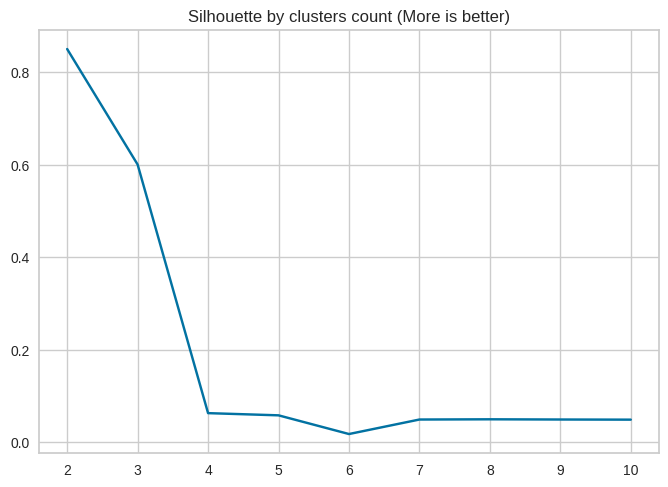

2

In [15]:
X = model.user_profile.drop('user_seq', axis=1)

result = dt.SilhouetteAnalisys.make_on(
    X,
    lambda X, k: KMedoids(n_clusters=k, random_state=random_state).fit(X),
    max_clusters=10
)

result.plot()
result.better_k()

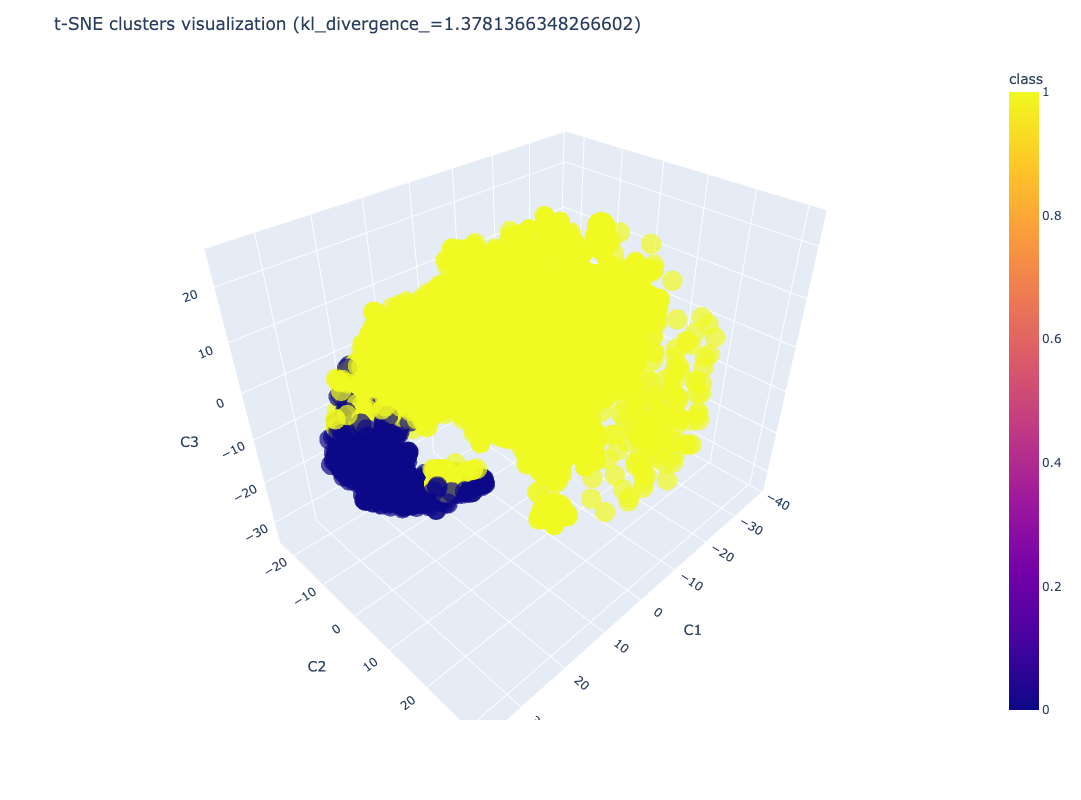

In [16]:
k = result.better_k()

y = KMedoids(n_clusters=k, random_state=random_state).fit(X).labels_

dt.TSNEAnalisys.make_on(X, y).plot()

In [17]:
user_profile_df = user_profiles_by_cluster(train_set_df, model, y)

for cluster in range(k):
    user_ids = user_profile_df.query(f'cluster == {cluster}')['user_seq'].values
    print(f'Cluster: {cluster}', user_ids[0])
    model.recommend(user_ids[0]).show()

Cluster: 0 79


Item Recommender: MultiFeatureUserProfileRecommender



Cluster: 1 898


Item Recommender: MultiFeatureUserProfileRecommender



In [15]:
predictor = ml.UserItemRecommenderPredictorAdapter(model)

predictor.predict(3545, 7235)

3.3333333333333335

In [38]:
eval_dl  = DataLoader(eval_set,  batch_size=3000, num_workers=24, pin_memory=True)
test_dl  = DataLoader(test_set,  batch_size=3000, num_workers=24, pin_memory=True)

In [39]:
ut.save_df(get_stacking_df(predictor, eval_set, eval_dl), STACKING_TRAIN_PATH)
ut.save_df(get_stacking_df(predictor, test_set, test_dl), STACKING_TEST_PATH)

UserProfileRecommender(genres, adults, year) batch prediction:   0%|          | 0/4 [00:00<?, ?it/s]

2023-11-04 12:52:37,884 - INFO - 0:03:19.26
2023-11-04 12:55:56,209 - INFO - 0:03:17.96
2023-11-04 12:59:15,231 - INFO - 0:03:18.65
2023-11-04 12:59:46,569 - INFO - 0:00:30.97


UserProfileRecommender(genres, adults, year) batch prediction:   0%|          | 0/2 [00:00<?, ?it/s]

2023-11-04 13:03:09,337 - INFO - 0:03:20.47
2023-11-04 13:04:59,262 - INFO - 0:01:49.52


Ordered by mAP@5(4,5):


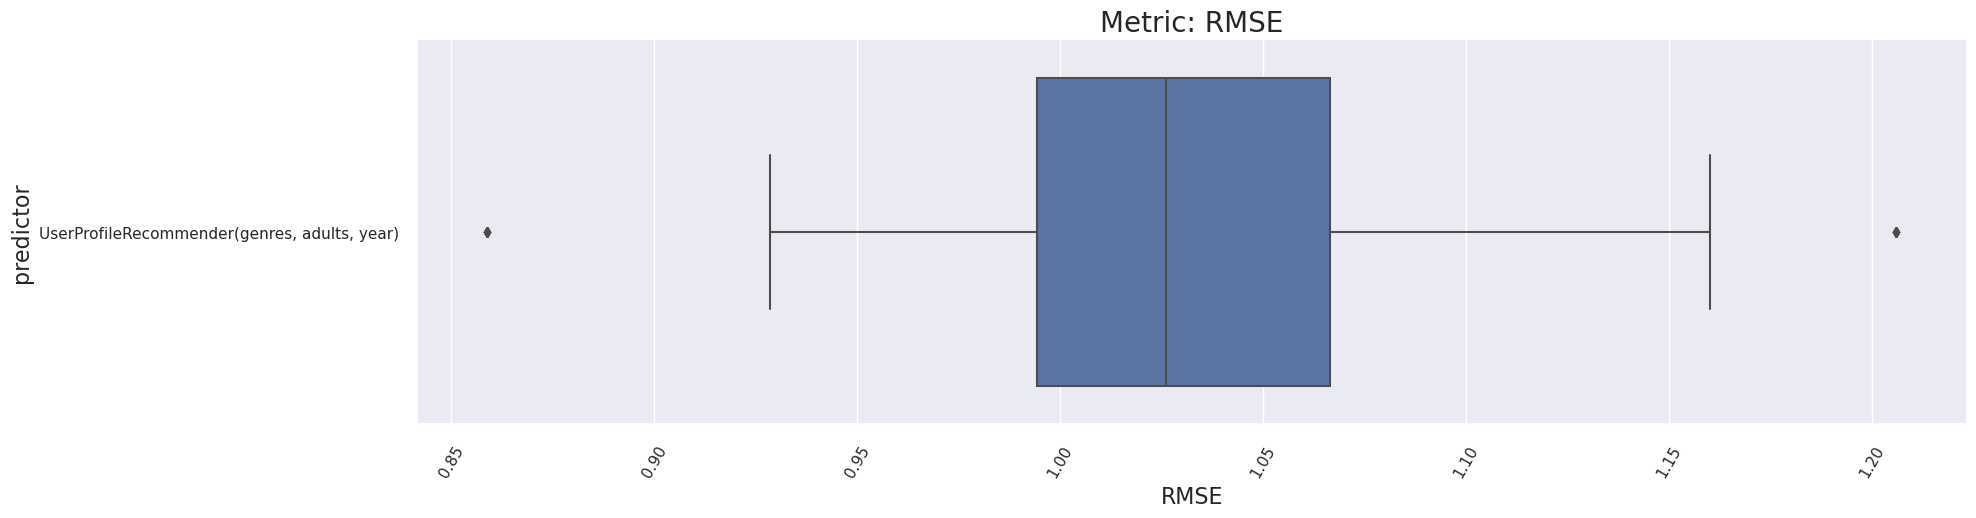

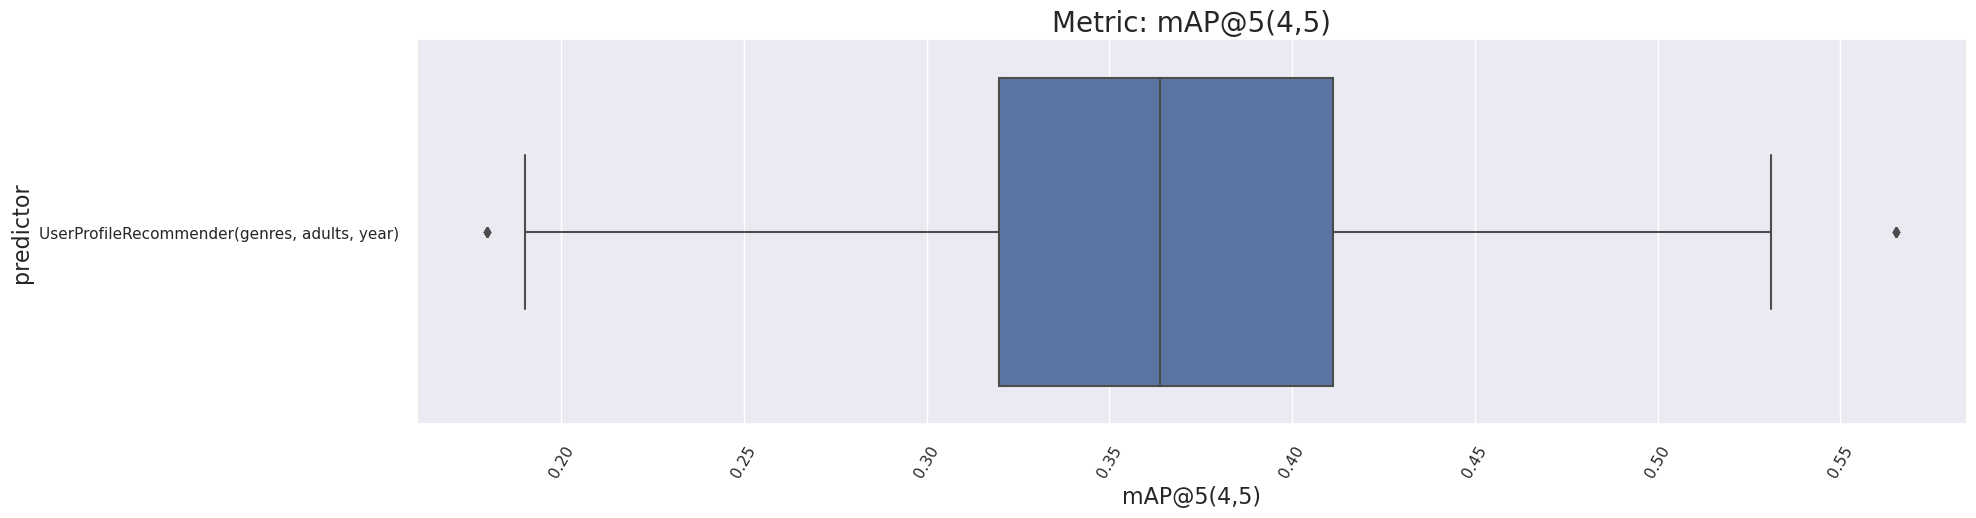

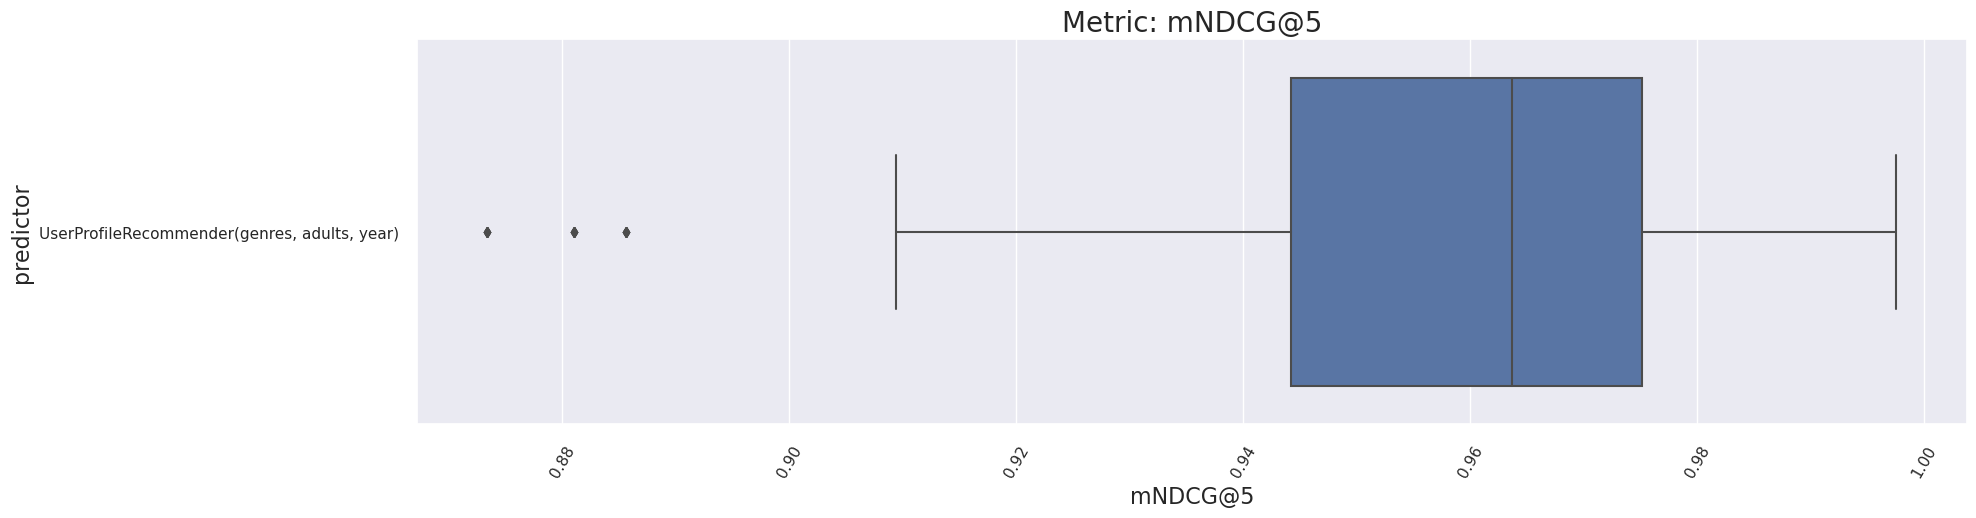

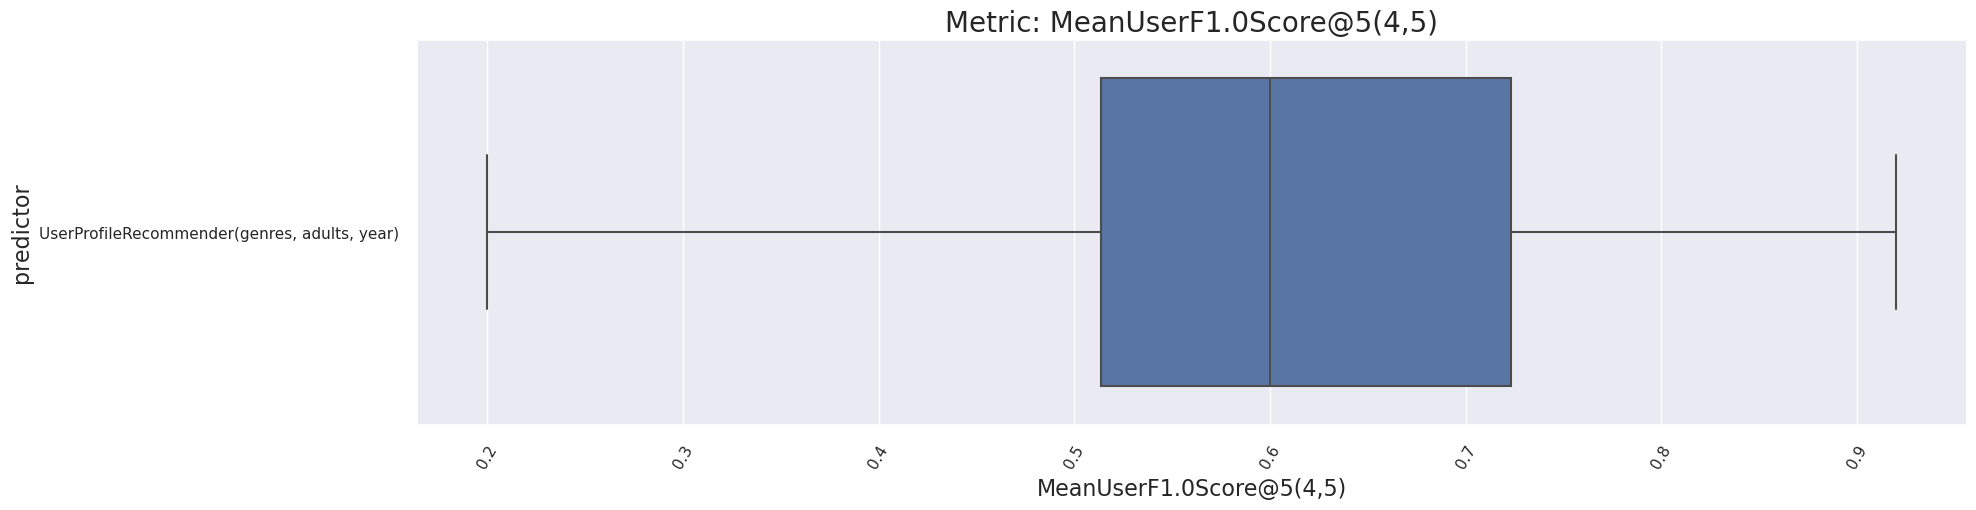

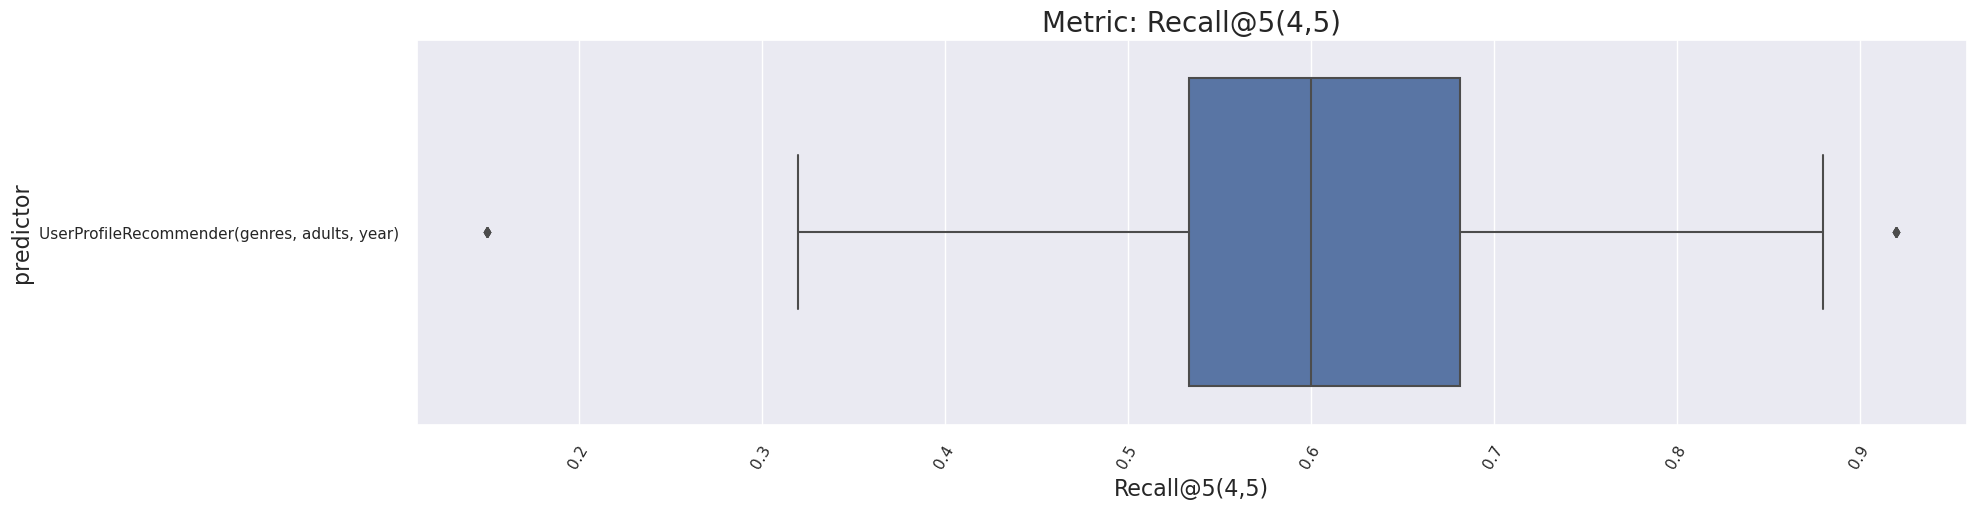

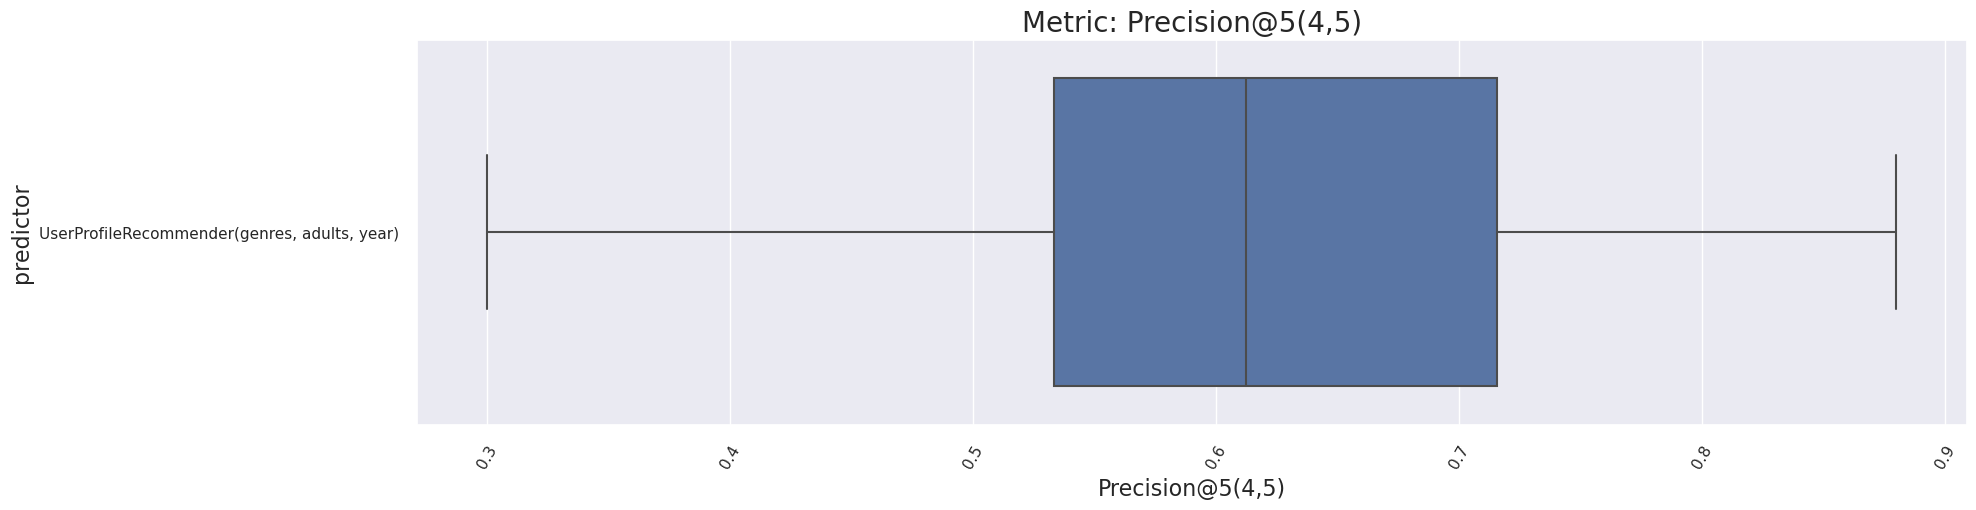

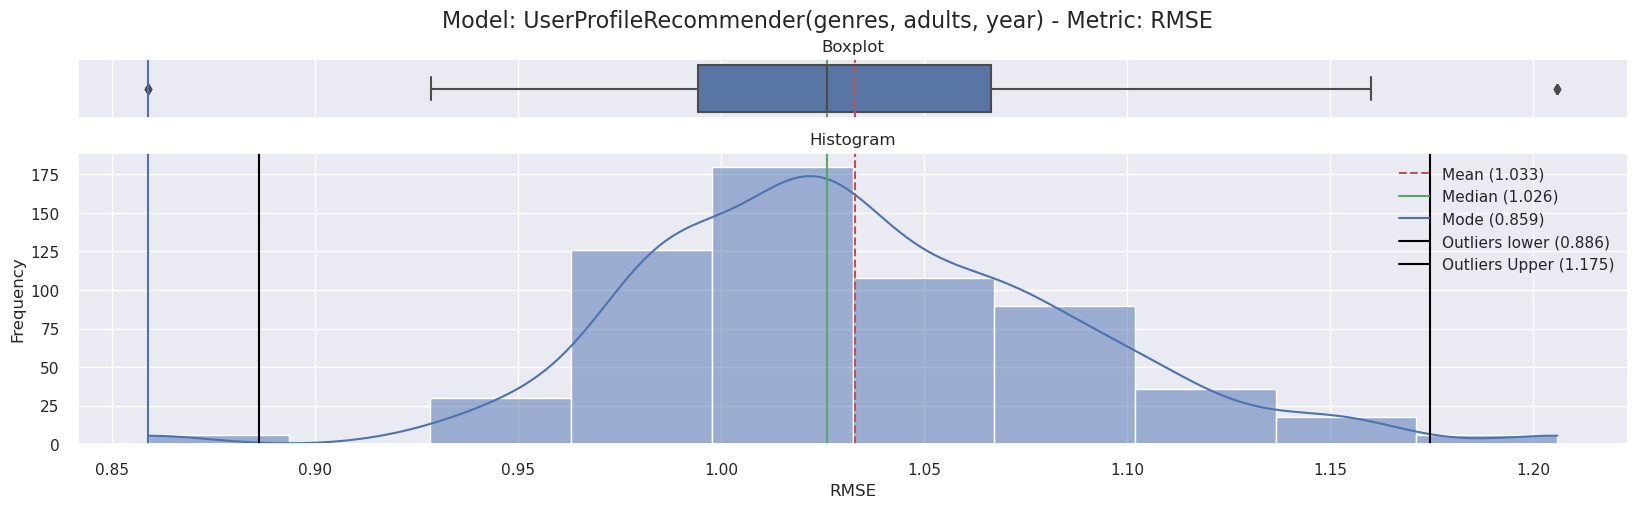

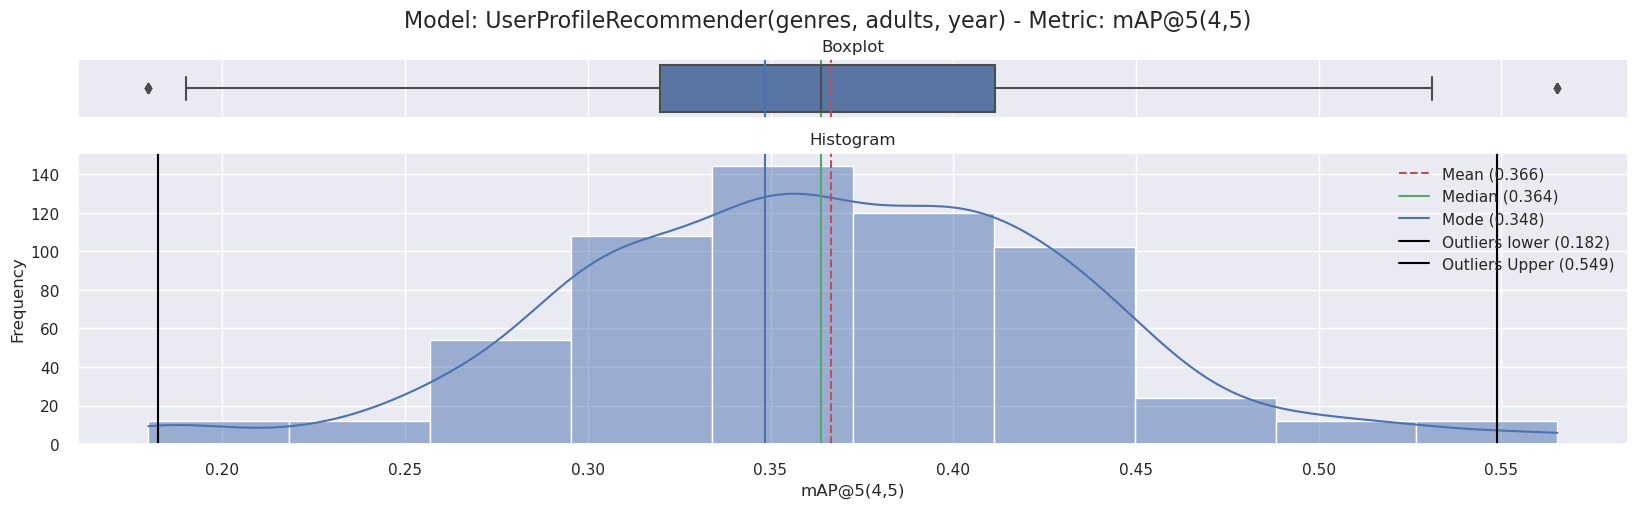

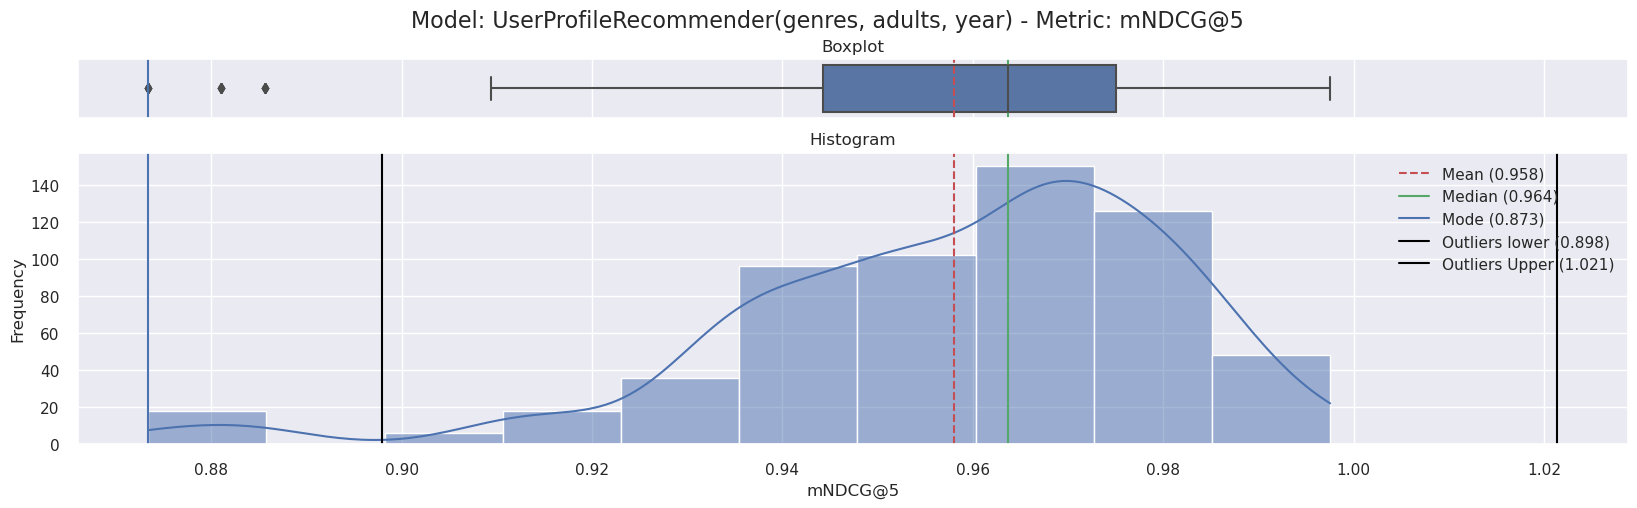

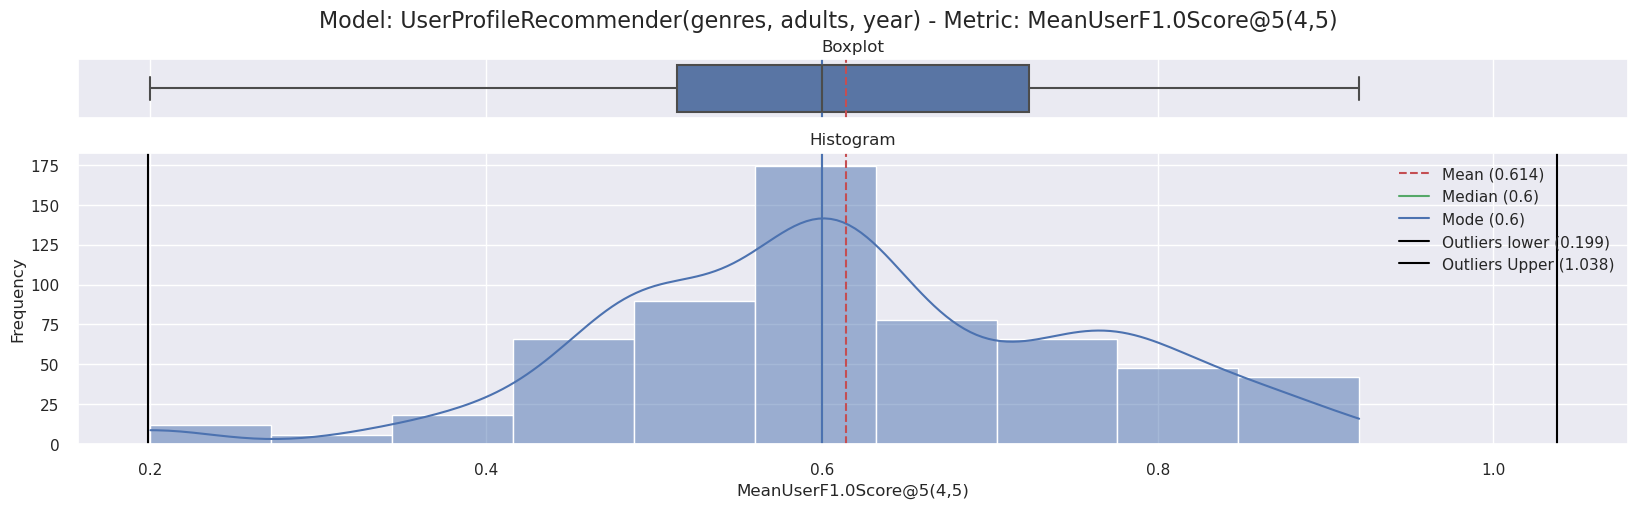

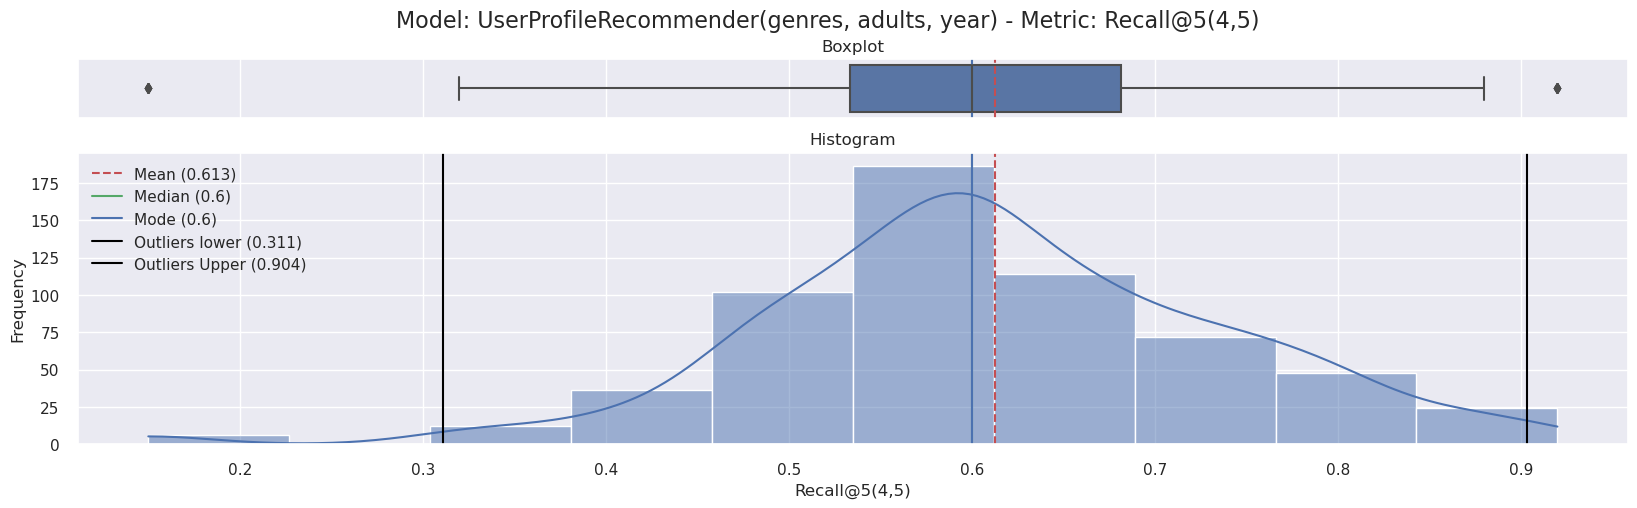

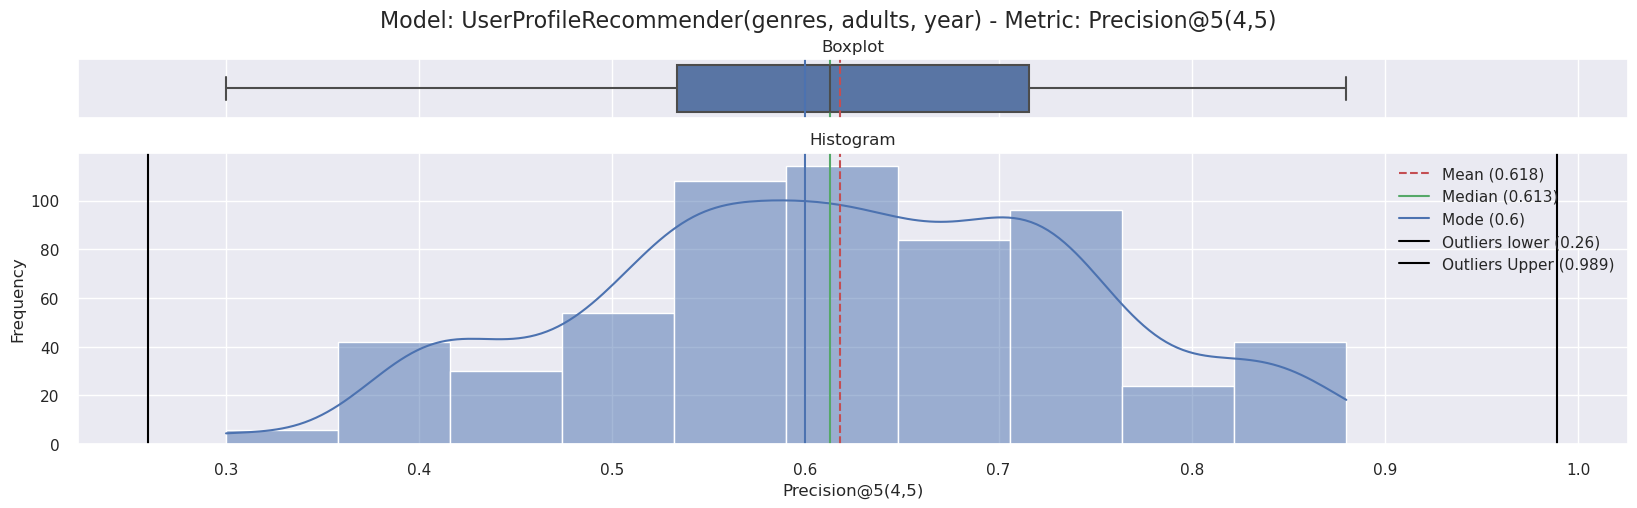

In [40]:
EVALUATE = False

if EVALUATE:
    n_classes = len(train_set_df.rating.unique())

    validator = ml.Validator(
        n_samples  = 100,
        batch_size = 200,
        metrics    = [
            mt.RMSE(),
            mt.MeanNdcgAtk            (k=5),
            mt.MeanAveragePrecisionAtk(k=5, discretizer=dr.between(4, 5)),
            mt.MeanUserFBetaScoreAtk  (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
            mt.MeanUserPrecisionAtk   (k=5, n_classes=n_classes, discretizer=dr.between(4, 5)),
            mt.MeanUserRecallAtk      (k=5, n_classes=n_classes, discretizer=dr.between(4, 5))
        ],
        predictors = [predictor]
    )

    summary = validator.validate(eval_set)
    summary.save(METRICS_PATH)
else:
    summary = ml.ValidatorSummary.load(METRICS_PATH)

summary.show()
summary.plot()